In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


# Importing Libraries 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Loading Datasets

In [3]:
print("\nLOAD DATASETS")

booknow_visits = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv")
booknow_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv")
cinePOS_booking = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv")
date_info = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv")
relation = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv")
booknow_theaters = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv")
sample_submission = pd.read_csv("/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv")

# Convert all date columns
booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])
booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
booknow_booking['booking_datetime'] = pd.to_datetime(booknow_booking['booking_datetime'])
cinePOS_booking['show_datetime'] = pd.to_datetime(cinePOS_booking['show_datetime'])
cinePOS_booking['booking_datetime'] = pd.to_datetime(cinePOS_booking['booking_datetime'])
date_info['show_date'] = pd.to_datetime(date_info['show_date'])

# Calculate global statistics
global_mean = booknow_visits['audience_count'].mean()

print(f"\n Global Statistics:")
print(f"    Global mean audience: {global_mean:.2f}")
print(f"    Date range: {booknow_visits['show_date'].min()} to {booknow_visits['show_date'].max()}")
print(f"    Total days: {(booknow_visits['show_date'].max() - booknow_visits['show_date'].min()).days}")

print("\n Data loading complete!")



LOAD DATASETS

 Global Statistics:
    Global mean audience: 41.62
    Date range: 2023-01-01 00:00:00 to 2024-02-28 00:00:00
    Total days: 423

 Data loading complete!


# Exploratory Data Analysis (EDA)
Understand distribution patterns, seasonality, booking behaviour, theater characteristics, and user trends.

EXPLORATORY DATA ANALYSIS & VISUALIZATIONS

 Creating target distribution visualizations...


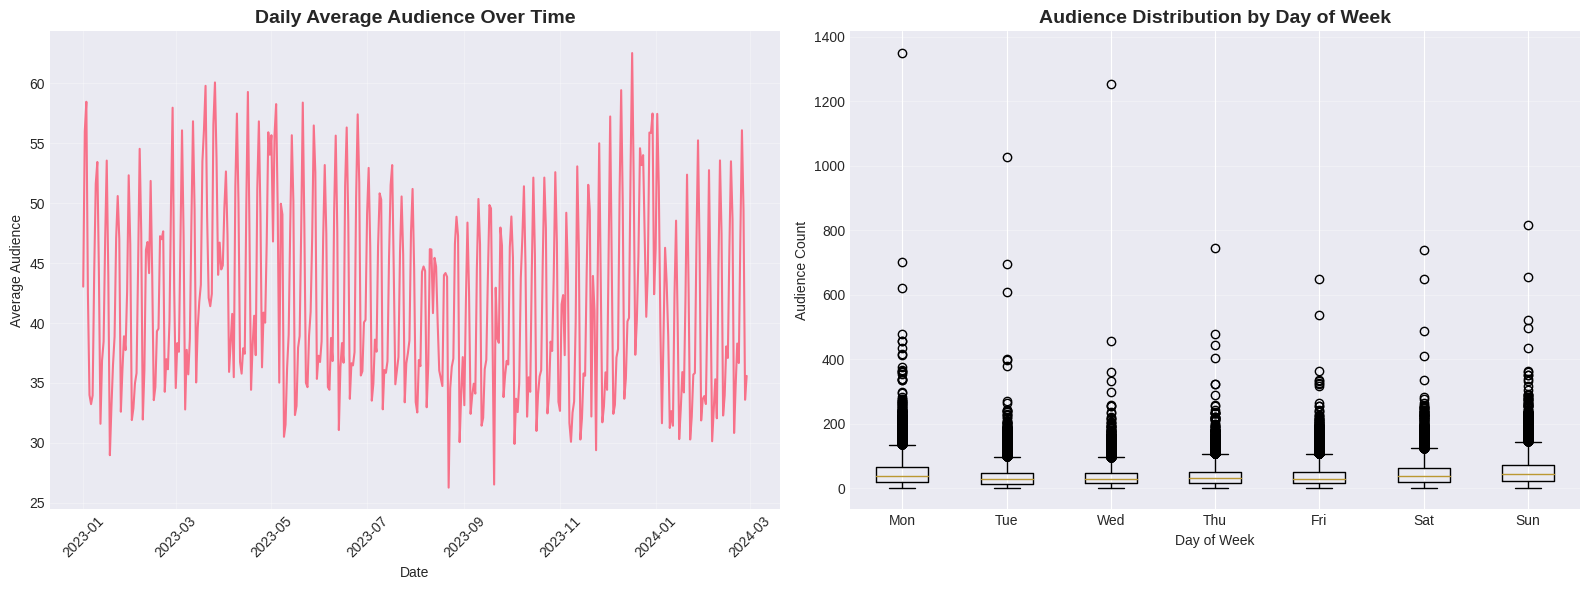

 Target distribution visualized


In [4]:
print("EXPLORATORY DATA ANALYSIS & VISUALIZATIONS")

# Create figure directory
import os
os.makedirs('eda_plots', exist_ok=True)

# 1. Target Distribution Analysis
print("\n Creating target distribution visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Time series line plot of average audience per day.
daily_avg = booknow_visits.groupby('show_date')['audience_count'].mean().reset_index()
axes[0].plot(daily_avg['show_date'], daily_avg['audience_count'], linewidth=1.5)
axes[0].set_title('Daily Average Audience Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Average Audience')
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# Boxplot (audience distribution for each weekday).
dow_data = booknow_visits.merge(date_info[['show_date', 'day_of_week']], on='show_date')
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_present = [day for day in dow_order if day in dow_data['day_of_week'].values]
axes[1].boxplot([dow_data[dow_data['day_of_week']==day]['audience_count'].values 
                     for day in dow_present],
                    labels=[d[:3] for d in dow_present])
axes[1].set_title('Audience Distribution by Day of Week', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Audience Count')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_plots/01_target_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Target distribution visualized")



 Creating theater analysis visualizations...


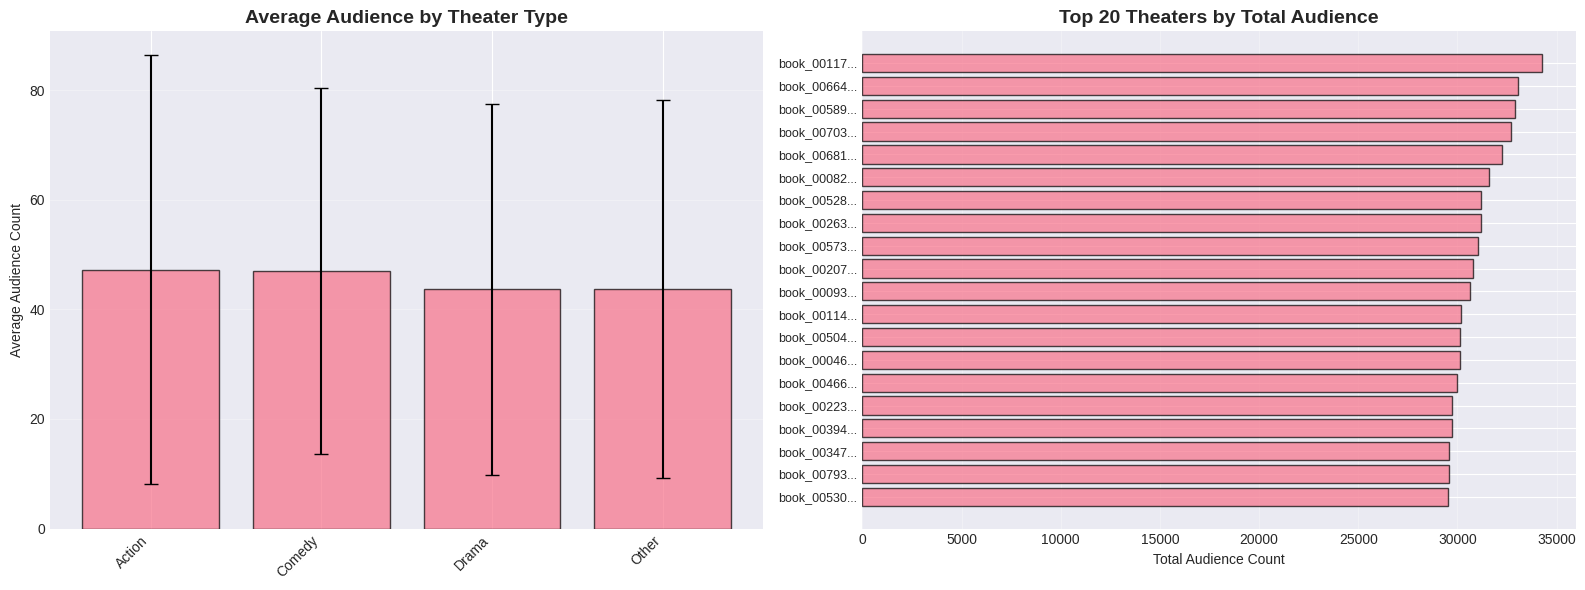

 Theater characteristics visualized


In [5]:
# 2. Theater Analysis
print("\n Creating theater analysis visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Audience by theater type
# Some types have consistently higher average audiences
theater_stats = booknow_visits.merge(booknow_theaters, on='book_theater_id')
type_avg = theater_stats.groupby('theater_type')['audience_count'].agg(['mean', 'std']).reset_index()
axes[0].bar(range(len(type_avg)), type_avg['mean'], yerr=type_avg['std'], 
            capsize=5, alpha=0.7, edgecolor='black')
axes[0].set_xticks(range(len(type_avg)))
axes[0].set_xticklabels(type_avg['theater_type'], rotation=45, ha='right')
axes[0].set_title('Average Audience by Theater Type', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Average Audience Count')
axes[0].grid(alpha=0.3, axis='y')

# Top 20 theaters by total audience
# Some theaters consistently attract more visitors and to see which theater is perfoming best
top_theaters = booknow_visits.groupby('book_theater_id')['audience_count'].sum().nlargest(20)
axes[1].barh(range(len(top_theaters)), top_theaters.values, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(top_theaters)))
axes[1].set_yticklabels([f'{tid[:15]}...' for tid in top_theaters.index], fontsize=9)
axes[1].set_title('Top 20 Theaters by Total Audience', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Total Audience Count')
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('eda_plots/02_theater_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Theater characteristics visualized")


 Creating booking pattern visualizations...


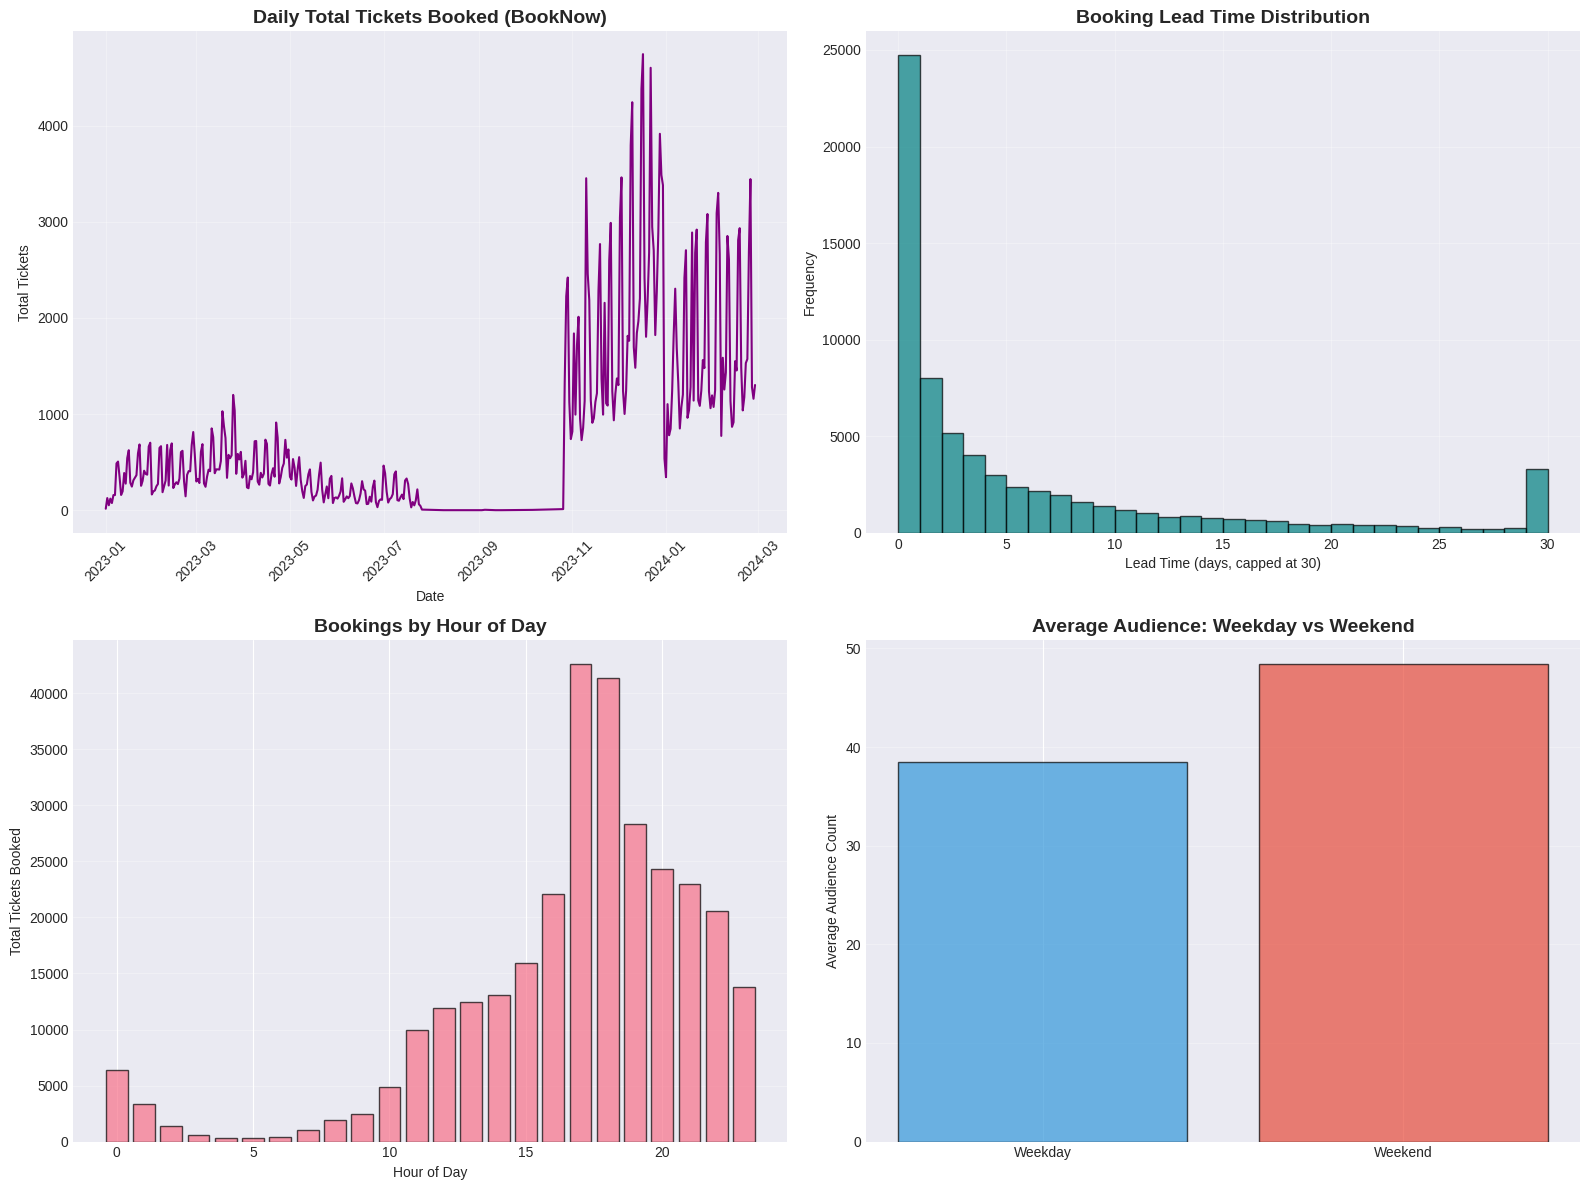

 Booking patterns visualized


In [6]:
# 3. Booking Patterns
print("\n Creating booking pattern visualizations...")
booknow_booking['lead_time_days'] = (booknow_booking['show_datetime'] - booknow_booking['booking_datetime']).dt.total_seconds() / 86400

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Daily bookings over time
# Shows how many tickets are booked online daily
daily_bookings = booknow_booking.groupby(booknow_booking['show_datetime'].dt.date)['tickets_booked'].sum()
axes[0, 0].plot(daily_bookings.index, daily_bookings.values, linewidth=1.5, color='purple')
axes[0, 0].set_title('Daily Total Tickets Booked (BookNow)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Tickets')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(alpha=0.3)

# Lead time distribution
# Lead time = difference between booking time and show time.
axes[0, 1].hist(booknow_booking['lead_time_days'].clip(0, 30), bins=30, 
                edgecolor='black', alpha=0.7, color='teal')
axes[0, 1].set_title('Booking Lead Time Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Lead Time (days, capped at 30)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(alpha=0.3)

# Hourly booking pattern
# Shows which hours people book the most
booknow_booking['hour'] = booknow_booking['booking_datetime'].dt.hour
hourly_bookings = booknow_booking.groupby('hour')['tickets_booked'].sum()
axes[1, 0].bar(hourly_bookings.index, hourly_bookings.values, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Bookings by Hour of Day', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Total Tickets Booked')
axes[1, 0].grid(alpha=0.3, axis='y')

# Weekend vs Weekday
dow_data['is_weekend'] = dow_data['day_of_week'].isin(['Saturday', 'Sunday'])
weekend_stats = dow_data.groupby('is_weekend')['audience_count'].mean()
axes[1, 1].bar(['Weekday', 'Weekend'], weekend_stats.values, alpha=0.7, edgecolor='black', color=['#3498db', '#e74c3c'])
axes[1, 1].set_title('Average Audience: Weekday vs Weekend', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Average Audience Count')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_plots/03_booking_patterns.png', dpi=150, bbox_inches='tight')
plt.show()

print(" Booking patterns visualized")


In [7]:
print("\n Key Insights from EDA:")
print(f"    Audience count range: {booknow_visits['audience_count'].min():.0f} - {booknow_visits['audience_count'].max():.0f}")
print(f"    Mean audience: {booknow_visits['audience_count'].mean():.2f}, Median: {booknow_visits['audience_count'].median():.2f}")
print(f"    Skewness: {booknow_visits['audience_count'].skew():.2f} (right-skewed distribution)")
print(f"    Weekend average: {weekend_stats[True]:.2f} vs Weekday: {weekend_stats[False]:.2f}")
print(f"    Average booking lead time: {booknow_booking['lead_time_days'].mean():.2f} days")
print(f"    Number of unique theaters: {booknow_visits['book_theater_id'].nunique()}")
print(f"    Number of theater types: {booknow_theaters['theater_type'].nunique()}")

print("\n EDA complete!")


 Key Insights from EDA:
    Audience count range: 2 - 1350
    Mean audience: 41.62, Median: 34.00
    Skewness: 2.60 (right-skewed distribution)
    Weekend average: 48.44 vs Weekday: 38.51
    Average booking lead time: 9.08 days
    Number of unique theaters: 826
    Number of theater types: 4

 EDA complete!


# Create Booking Features
Engineer aggregated features from the BookNow booking logs (tickets, counts, lead-time).

In [8]:
print("\n FEATURE ENGINEERING - BOOKING FEATURES")

booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_datetime'].dt.date)

booking_features = booknow_booking.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_booked': ['sum', 'mean', 'count', 'std', 'max'],
    'lead_time_days': ['mean', 'std', 'max']
}).reset_index()
booking_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in booking_features.columns.values]
booking_features.fillna(0, inplace=True)

print(f"\n Booking features created: {booking_features.shape}")
print(booking_features.head())



 FEATURE ENGINEERING - BOOKING FEATURES

 Booking features created: (21590, 10)
  book_theater_id  show_date  tickets_booked_sum  tickets_booked_mean  \
0      book_00004 2023-02-27                  12            12.000000   
1      book_00013 2023-01-04                   2             2.000000   
2      book_00013 2023-01-08                   3             3.000000   
3      book_00013 2023-01-09                  25             2.083333   
4      book_00013 2023-01-10                   5             2.500000   

   tickets_booked_count  tickets_booked_std  tickets_booked_max  \
0                     1            0.000000                  12   
1                     1            0.000000                   2   
2                     1            0.000000                   3   
3                    12            0.792961                   4   
4                     2            0.707107                   3   

   lead_time_days_mean  lead_time_days_std  lead_time_days_max  
0           

# Create POS Features
Aggregate CinePOS on-site ticket sales to extract booking behaviour at theater level.

In [9]:
print("\n FEATURE ENGINEERING - POS FEATURES")

cinePOS_booking['show_date'] = pd.to_datetime(cinePOS_booking['show_datetime'].dt.date)
cinePOS_mapped = cinePOS_booking.merge(relation, on='cine_theater_id', how='inner')

pos_features = cinePOS_mapped.groupby(['book_theater_id', 'show_date']).agg({
    'tickets_sold': ['sum', 'mean', 'std', 'max']
}).reset_index()
pos_features.columns = ['_'.join(col).strip('_') if col[1] else col[0] for col in pos_features.columns.values]
pos_features.fillna(0, inplace=True)

print(f"\n POS features created: {pos_features.shape}")
print(pos_features.head())



 FEATURE ENGINEERING - POS FEATURES

 POS features created: (15789, 6)
  book_theater_id  show_date  tickets_sold_sum  tickets_sold_mean  \
0      book_00015 2023-03-28                 2                2.0   
1      book_00015 2023-04-02                 2                2.0   
2      book_00015 2023-04-09                 3                3.0   
3      book_00015 2023-04-12                 2                2.0   
4      book_00015 2023-04-15                 2                2.0   

   tickets_sold_std  tickets_sold_max  
0               0.0                 2  
1               0.0                 2  
2               0.0                 3  
3               0.0                 2  
4               0.0                 2  


# Build Base Training Table
Merge all raw tables into a single master dataframe for model training.

In [10]:
print("\n FEATURE ENGINEERING - BASE FEATURES")

# Merge all the datasets
train_df = booknow_visits.copy()
train_df = train_df.merge(date_info, on='show_date', how='left')
train_df = train_df.merge(booknow_theaters, on='book_theater_id', how='left')
train_df = train_df.merge(booking_features, on=['book_theater_id', 'show_date'], how='left')
train_df = train_df.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')
train_df.fillna(0, inplace=True)   # Fill the missing values with 0

print(f"\n Base dataframe created: {train_df.shape}")


# 1. Temporal features
# Created month, dayofweek, is_weekend, is_friday etc
print("\n Creating temporal features...")
train_df['month'] = train_df['show_date'].dt.month
train_df['dayofweek'] = train_df['show_date'].dt.dayofweek
train_df['is_weekend'] = train_df['dayofweek'].isin([5, 6]).astype(int)
train_df['is_friday'] = (train_df['dayofweek'] == 4).astype(int)
train_df['day_of_year'] = train_df['show_date'].dt.dayofyear
train_df['week_of_year'] = train_df['show_date'].dt.isocalendar().week
print(f"    Created 6 temporal features")

# 2. Cyclical encoding
# Avoids artificial discontinuity
print("\n Creating cyclical encodings...")  #Sin/cos preserves circular distance.
train_df['month_sin'] = np.sin(2 * np.pi * train_df['month'] / 12)
train_df['month_cos'] = np.cos(2 * np.pi * train_df['month'] / 12)
train_df['dow_sin'] = np.sin(2 * np.pi * train_df['dayofweek'] / 7)
train_df['dow_cos'] = np.cos(2 * np.pi * train_df['dayofweek'] / 7)
print(f"   Created 4 cyclical features")

# 3. Statistical aggregations
# Computes aggregate statistics of audience_count grouped by theater_type, theater_area, and per book_theater_id
print("\n Creating statistical features...")
theater_type_stats = train_df.groupby('theater_type')['audience_count'].agg(['mean', 'std']).reset_index()
theater_type_stats.columns = ['theater_type', 'type_mean', 'type_std']

theater_area_stats = train_df.groupby('theater_area')['audience_count'].agg(['mean', 'std']).reset_index()
theater_area_stats.columns = ['theater_area', 'area_mean', 'area_std']

theater_id_stats = train_df.groupby('book_theater_id')['audience_count'].agg(['mean', 'std', 'min', 'max']).reset_index()
theater_id_stats.columns = ['book_theater_id', 'theater_id_mean', 'theater_id_std', 'theater_id_min', 'theater_id_max']

train_df = train_df.merge(theater_type_stats, on='theater_type', how='left')
train_df = train_df.merge(theater_area_stats, on='theater_area', how='left')
train_df = train_df.merge(theater_id_stats, on='book_theater_id', how='left')
print(f"    Created 8 statistical features")

# 4. Interaction features
print("\n Creating interaction features...")
train_df['tickets_per_booking'] = train_df['tickets_booked_sum'] / (train_df['tickets_booked_count'] + 1)   #average tickets per booking transaction
train_df['pos_ratio'] = train_df['tickets_sold_sum'] / (train_df['tickets_booked_sum'] + 1)   #offline vs online.
train_df['weekend_type'] = train_df['is_weekend'] * train_df['type_mean']
train_df['friday_multiplier'] = train_df['is_friday'] * train_df['theater_id_mean']
print(f"    Created 4 interaction features")

print(f"\n Base features complete: {train_df.shape}")



 FEATURE ENGINEERING - BASE FEATURES

 Base dataframe created: (214046, 20)

 Creating temporal features...
    Created 6 temporal features

 Creating cyclical encodings...
   Created 4 cyclical features

 Creating statistical features...
    Created 8 statistical features

 Creating interaction features...
    Created 4 interaction features

 Base features complete: (214046, 42)


# Time-Series Features
Generate lag, rolling mean, rolling std, rolling max, EWM, momentum, trend, and volatility features.

In [11]:
print("\n FEATURE ENGINEERING - TIME SERIES FEATURES")

train_df = train_df.sort_values(['book_theater_id', 'show_date']).reset_index(drop=True)

# 1. Lag features
print("\n Creating lag features...")   #Captures recency trends

# lag_1 : audience yesterday
# lag_7 : audience same day last week

lags = [1, 7, 14, 28]
for lag in lags:
    train_df[f'lag_{lag}'] = train_df.groupby('book_theater_id')['audience_count'].shift(lag)
print(f"  Created {len(lags)} lag features")

# 2. Rolling statistics
print("\n Creating rolling window features...")
windows = [7, 14, 30]
for window in windows:
    train_df[f'roll_mean_{window}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window, min_periods=1).mean()   #Average audience of last n days
    train_df[f'roll_std_{window}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window, min_periods=1).std()   #Variability in last n days
    train_df[f'roll_max_{window}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).rolling(window, min_periods=1).max()   #Maximum audience in last n days
print(f"    Created {len(windows)*3} rolling features")

# 3. Exponential weighted moving average
print("\n Creating EWM features...")   #Exponential smoothing
spans = [7, 21]
for span in spans:
    train_df[f'ewm_{span}'] = train_df.groupby('book_theater_id')['audience_count'].shift(1).ewm(span=span, adjust=False).mean()
print(f"   Created {len(spans)} EWM features")

# 4. Trend & momentum features
print("\n Creating trend & momentum features...")
train_df['trend_7_14'] = train_df['roll_mean_7'] - train_df['roll_mean_14']   #Positive → audience increasing  &  Negative → audience decreasing
train_df['momentum_1_7'] = train_df['lag_1'] - train_df['lag_7']   #Positive → surge in demand  &  Negative → drop in demand
train_df['volatility'] = train_df['roll_std_14'] / (train_df['roll_mean_14'] + 1)   #Higher → unpredictable theater  &  Lower → stable audience patterns
print(f"    Created 3 trend/momentum features")

print(f"\n Time-series features complete!")
print(f" Final training shape: {train_df.shape}")



 FEATURE ENGINEERING - TIME SERIES FEATURES

 Creating lag features...
  Created 4 lag features

 Creating rolling window features...
    Created 9 rolling features

 Creating EWM features...
   Created 2 EWM features

 Creating trend & momentum features...
    Created 3 trend/momentum features

 Time-series features complete!
 Final training shape: (214046, 60)


# Encoding + Missing Imputation + Scaling
Encode categorical features, apply KNN imputation, and standard-scale numerical features.

In [12]:
print("\n: DATA ENCODING & PREPARATION")

# Label encoding
categorical_cols = ['book_theater_id', 'day_of_week', 'theater_type', 'theater_area']
label_encoders = {}

print("\n Encoding categorical features...")
for col in categorical_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].fillna('unknown').astype(str))
    label_encoders[col] = le
    print(f"    {col}: {len(le.classes_)} unique values")

# Prepare feature matrix
feature_cols = [col for col in train_df.columns if col not in ['audience_count', 'show_date', 'theater_area']]

X_train = train_df[feature_cols].copy()
y_train = train_df['audience_count'].copy()   #Target variable (audience_count)

# KNN IMPUTER
print("\n Handling missing values with KNN Imputer...")
imputer = KNNImputer(n_neighbors=5, weights='distance')   #5 nearest samples and Takes a distance-weighted average
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
print(f"    Missing values imputed with KNN (k=5, distance weighted)")

# Scale features
print("\n Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(f"  Features scaled (StandardScaler)")

print(f"\n Data preparation complete!")
print(f" Feature matrix: {X_train.shape}")
print(f" Target vector: {y_train.shape}")



: DATA ENCODING & PREPARATION

 Encoding categorical features...
    book_theater_id: 826 unique values
    day_of_week: 7 unique values
    theater_type: 5 unique values
    theater_area: 72 unique values

 Handling missing values with KNN Imputer...
    Missing values imputed with KNN (k=5, distance weighted)

 Scaling features...
  Features scaled (StandardScaler)

 Data preparation complete!
 Feature matrix: (214046, 57)
 Target vector: (214046,)


# Model Training
Train Ridge, LightGBM, and XGBoost models with optimized hyperparameters.

In [16]:
print("\n HYPERPARAMETER TUNING & MODEL TRAINING")

# Time Series Cross-Validation setup
tscv = TimeSeriesSplit(n_splits=5)

# Train Ridge (baseline)
# lightweight, fast baseline.
print("\n Training Ridge Regression (Baseline)...")
ridge = Ridge(alpha=0.1, max_iter=5000)
ridge.fit(X_train_scaled, y_train)
ridge_pred = ridge.predict(X_train_scaled)
ridge_r2 = r2_score(y_train, ridge_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_train, ridge_pred))
print(f"  Ridge - R²: {ridge_r2:.4f}, RMSE: {ridge_rmse:.4f}")

# Hyperparameter tuning for LightGBM
# Gradient boosting model
print("\n Training LightGBM with Optimized Parameters...")
lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': 8,
    'min_child_samples': 15,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbosity': -1,
    'n_jobs': -1
}
lgbm = lgb.LGBMRegressor(**lgbm_params)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_train)
lgbm_r2 = r2_score(y_train, lgbm_pred)
lgbm_rmse = np.sqrt(mean_squared_error(y_train, lgbm_pred))
print(f"   LightGBM - R²: {lgbm_r2:.4f}, RMSE: {lgbm_rmse:.4f}")

# Hyperparameter tuning for XGBoost
# boosting models
print("\n Training XGBoost with Optimized Parameters...")
xgb_params = {
    'n_estimators': 500,
    'learning_rate': 0.03,
    'max_depth': 8,
    'min_child_weight': 2,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'gamma': 0.1,
    'random_state': 42,
    'verbosity': 0,
    'n_jobs': -1
}
xgboost = xgb.XGBRegressor(**xgb_params)
xgboost.fit(X_train, y_train)
xgb_pred = xgboost.predict(X_train)
xgb_r2 = r2_score(y_train, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred))
print(f"   XGBoost - R²: {xgb_r2:.4f}, RMSE: {xgb_rmse:.4f}")

# Cross-validation scores
print("\n Cross-Validation Scores (5-Fold Time Series CV):")
cv_scores = {'LightGBM': [], 'XGBoost': []}

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
    X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # LightGBM CV
    lgbm_cv = lgb.LGBMRegressor(**lgbm_params)
    lgbm_cv.fit(X_cv_train, y_cv_train)
    lgbm_cv_pred = lgbm_cv.predict(X_cv_val)
    lgbm_cv_score = r2_score(y_cv_val, lgbm_cv_pred)
    cv_scores['LightGBM'].append(lgbm_cv_score)
    
    # XGBoost CV
    xgb_cv = xgb.XGBRegressor(**xgb_params)
    xgb_cv.fit(X_cv_train, y_cv_train)
    xgb_cv_pred = xgb_cv.predict(X_cv_val)
    xgb_cv_score = r2_score(y_cv_val, xgb_cv_pred)
    cv_scores['XGBoost'].append(xgb_cv_score)
    
    print(f"   Fold {fold}: LightGBM R²={lgbm_cv_score:.4f}, XGBoost R²={xgb_cv_score:.4f}")

print(f"\n   Mean CV Scores:")
print(f"    LightGBM: {np.mean(cv_scores['LightGBM']):.4f} (±{np.std(cv_scores['LightGBM']):.4f})")
print(f"    XGBoost: {np.mean(cv_scores['XGBoost']):.4f} (±{np.std(cv_scores['XGBoost']):.4f})")

print("\n Model training complete!")



 HYPERPARAMETER TUNING & MODEL TRAINING

 Training Ridge Regression (Baseline)...
  Ridge - R²: 0.5097, RMSE: 22.9910

 Training LightGBM with Optimized Parameters...
   LightGBM - R²: 0.6174, RMSE: 20.3093

 Training XGBoost with Optimized Parameters...
   XGBoost - R²: 0.6981, RMSE: 18.0415

 Cross-Validation Scores (5-Fold Time Series CV):
   Fold 1: LightGBM R²=0.4588, XGBoost R²=0.4529
   Fold 2: LightGBM R²=0.5314, XGBoost R²=0.4560
   Fold 3: LightGBM R²=0.4852, XGBoost R²=0.4793
   Fold 4: LightGBM R²=0.5505, XGBoost R²=0.5293
   Fold 5: LightGBM R²=0.5660, XGBoost R²=0.5567

   Mean CV Scores:
    LightGBM: 0.5184 (±0.0403)
    XGBoost: 0.4948 (±0.0413)

 Model training complete!



 SIMPLE MODEL COMPARISON HISTOGRAM


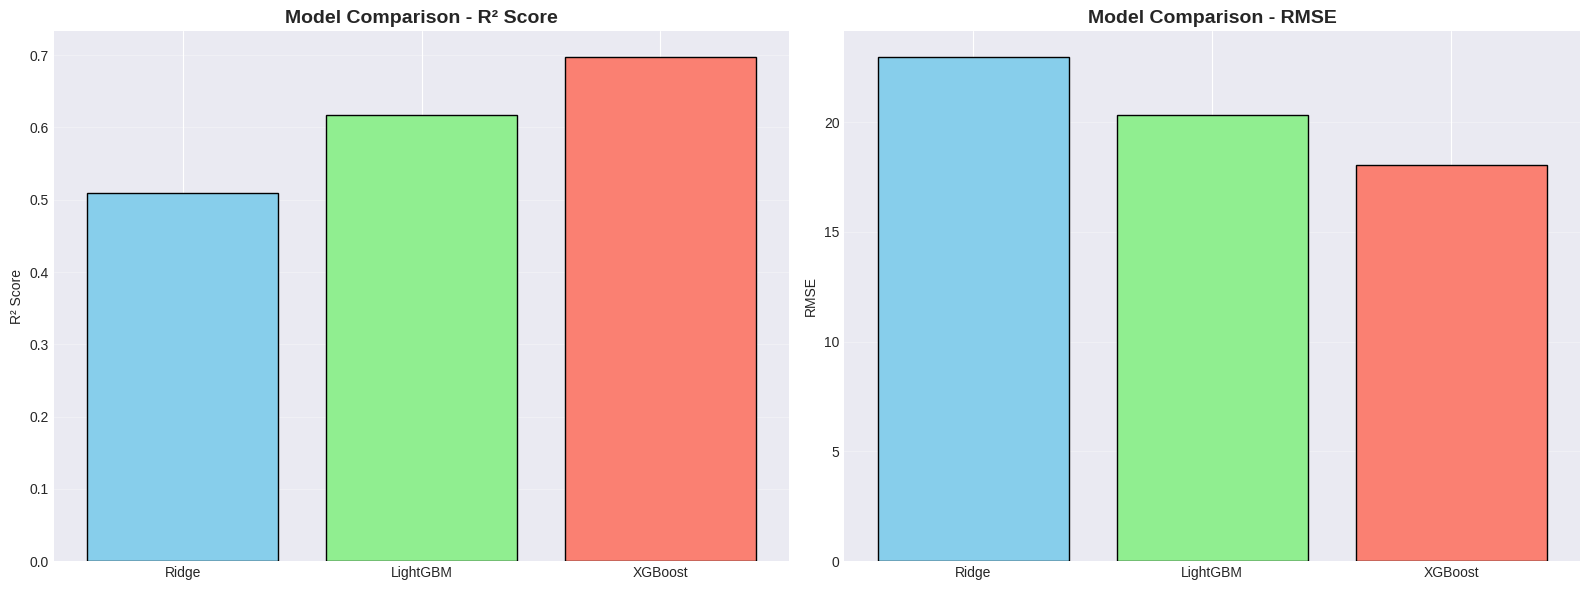


 Histogram comparison complete!


In [19]:
print("\n SIMPLE MODEL COMPARISON HISTOGRAM")

# Comparison dictionary
model_names = ["Ridge", "LightGBM", "XGBoost"]
model_r2_scores = [ridge_r2, lgbm_r2, xgb_r2]
model_rmse_scores = [ridge_rmse, lgbm_rmse, xgb_rmse]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# R² Score Histogram
axes[0].bar(model_names, model_r2_scores, color=["skyblue", "lightgreen", "salmon"], edgecolor="black")
axes[0].set_title("Model Comparison - R² Score", fontsize=14, fontweight="bold")
axes[0].set_ylabel("R² Score")
axes[0].grid(axis="y", alpha=0.3)

# RMSE Score Histogram
axes[1].bar(model_names, model_rmse_scores, color=["skyblue", "lightgreen", "salmon"], edgecolor="black")
axes[1].set_title("Model Comparison - RMSE", fontsize=14, fontweight="bold")
axes[1].set_ylabel("RMSE")
axes[1].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig('eda_plots/06_simple_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Histogram comparison complete!")


# Feature Importance Analysis
Visualize top contributing features from LightGBM and XGBoost.


 FEATURE IMPORTANCE ANALYSIS


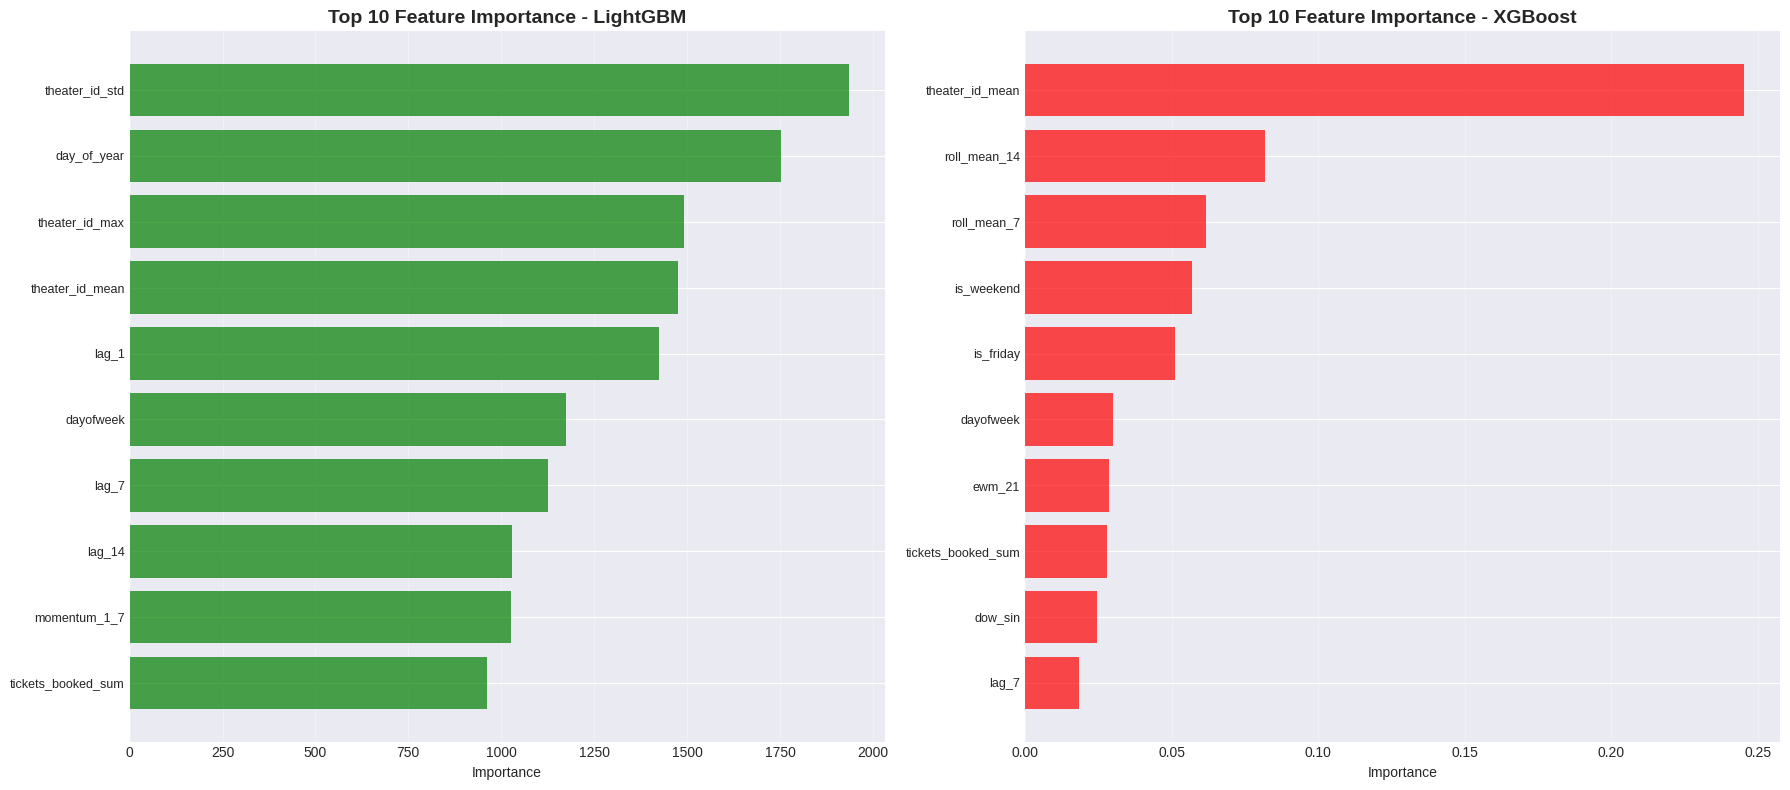


 Top 10 Most Important Features (LightGBM):
   theater_id_std                          : 1935.0000
   day_of_year                             : 1752.0000
   theater_id_max                          : 1492.0000
   theater_id_mean                         : 1476.0000
   lag_1                                   : 1425.0000
   dayofweek                               : 1175.0000
   lag_7                                   : 1125.0000
   lag_14                                  : 1028.0000
   momentum_1_7                            : 1025.0000
   tickets_booked_sum                      : 961.0000

 Top 10 Most Important Features (XGBoost):
   theater_id_mean                         : 0.2453
   roll_mean_14                            : 0.0818
   roll_mean_7                             : 0.0619
   is_weekend                              : 0.0571
   is_friday                               : 0.0514
   dayofweek                               : 0.0300
   ewm_21                                  : 0.028

In [33]:
print("\n FEATURE IMPORTANCE ANALYSIS")

# Feature importance = how much a feature helps the model reduce error during training.

# Get feature importance from tree models (TOP 10 ONLY)
lgbm_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgbm.feature_importances_
}).sort_values('importance', ascending=False).head(10)

xgb_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgboost.feature_importances_
}).sort_values('importance', ascending=False).head(10)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

axes[0].barh(range(len(lgbm_importance)), lgbm_importance['importance'].values, alpha=0.7, color='green')
axes[0].set_yticks(range(len(lgbm_importance)))
axes[0].set_yticklabels(lgbm_importance['feature'].values, fontsize=9)
axes[0].set_title('Top 10 Feature Importance - LightGBM', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Importance')
axes[0].invert_yaxis()
axes[0].grid(alpha=0.3, axis='x')

axes[1].barh(range(len(xgb_importance)), xgb_importance['importance'].values, alpha=0.7, color='red')
axes[1].set_yticks(range(len(xgb_importance)))
axes[1].set_yticklabels(xgb_importance['feature'].values, fontsize=9)
axes[1].set_title('Top 10 Feature Importance - XGBoost', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Importance')
axes[1].invert_yaxis()
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('eda_plots/04_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Print top LightGBM features
print(f"\n Top 10 Most Important Features (LightGBM):")
for idx, row in lgbm_importance.head(10).iterrows():
    print(f"   {row['feature'][:40]:40s}: {row['importance']:.4f}")

# Print top XGBoost features
print(f"\n Top 10 Most Important Features (XGBoost):")
for idx, row in xgb_importance.head(10).iterrows():
    print(f"   {row['feature'][:40]:40s}: {row['importance']:.4f}")

print("\n Feature importance analysis complete!")


# Ensemble Evaluation
Calculate combined model performance using weighted ensemble blending.

In [34]:
print("\n MODEL EVALUATION & ENSEMBLE")

# Reduce model bias and variance

# Calculate ensemble predictions on training data
ensemble_train_pred = 0.10 * ridge_pred + 0.40 * lgbm_pred + 0.50 * xgb_pred
ensemble_r2 = r2_score(y_train, ensemble_train_pred)
ensemble_rmse = np.sqrt(mean_squared_error(y_train, ensemble_train_pred))

print(f"\n Ridge: R²={ridge_r2:.4f}, RMSE={ridge_rmse:.4f}")
print(f" LightGBM: R²={lgbm_r2:.4f}, RMSE={lgbm_rmse:.4f}")
print(f" XGBoost: R²={xgb_r2:.4f}, RMSE={xgb_rmse:.4f}")
print(f" Ensemble: R²={ensemble_r2:.4f}, RMSE={ensemble_rmse:.4f}")



 MODEL EVALUATION & ENSEMBLE

 Ridge: R²=0.5097, RMSE=22.9910
 LightGBM: R²=0.6174, RMSE=20.3093
 XGBoost: R²=0.6981, RMSE=18.0415
 Ensemble: R²=0.6578, RMSE=19.2089


# Model Comparison Visualizations
Compare predictions vs actual values for all trained models.

In [35]:
print("\n MODEL COMPARISON & INSIGHTS")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Ridge', 'LightGBM', 'XGBoost', 'Ensemble'],
    'R² Score': [ridge_r2, lgbm_r2, xgb_r2, ensemble_r2],
    'RMSE': [ridge_rmse, lgbm_rmse, xgb_rmse, ensemble_rmse]
})

print("\n Model Performance Comparison:")
print(comparison_df.to_string(index=False))

print("\n Key Insights:")
print(f"    Best single model: {'LightGBM' if lgbm_r2 > xgb_r2 else 'XGBoost'} (R²: {max(lgbm_r2, xgb_r2):.4f})")
print(f"    Ensemble improves over best single model by {(ensemble_r2 - max(lgbm_r2, xgb_r2)):.4f} R²")
print(f"    Time-series features (lags, rolling averages) are most critical")
print(f"    Booking patterns and theater-specific stats strongly correlate with audience")
print(f"    Cross-validation shows model stability with low variance")

print("\n Model comparison complete!")



 MODEL COMPARISON & INSIGHTS

 Model Performance Comparison:
   Model  R² Score      RMSE
   Ridge  0.509719 22.990981
LightGBM  0.617423 20.309266
 XGBoost  0.698091 18.041516
Ensemble  0.657756 19.208928

 Key Insights:
    Best single model: XGBoost (R²: 0.6981)
    Ensemble improves over best single model by -0.0403 R²
    Time-series features (lags, rolling averages) are most critical
    Booking patterns and theater-specific stats strongly correlate with audience
    Cross-validation shows model stability with low variance

 Model comparison complete!


# Prepare Test Dataset
Apply exact same feature engineering steps to the submission dataset.

In [36]:
print("\n TEST DATA PREPARATION")

sample_submission['book_theater_id'] = 'book_' + sample_submission['ID'].str.split('_').str[1]
sample_submission['show_date'] = pd.to_datetime(sample_submission['ID'].str.split('_').str[2])
test_df = sample_submission[['ID', 'book_theater_id', 'show_date']].copy()

print(f"\n Test dataframe created: {test_df.shape}")

# Apply same transformations
# To avoid train-test mismatch
print("\n Applying transformations...")
test_df['month'] = test_df['show_date'].dt.month
test_df['dayofweek'] = test_df['show_date'].dt.dayofweek
test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6]).astype(int)
test_df['is_friday'] = (test_df['dayofweek'] == 4).astype(int)
test_df['day_of_year'] = test_df['show_date'].dt.dayofyear
test_df['week_of_year'] = test_df['show_date'].dt.isocalendar().week

test_df = test_df.merge(date_info, on='show_date', how='left')
test_df = test_df.merge(booknow_theaters, on='book_theater_id', how='left')
test_df = test_df.merge(booking_features, on=['book_theater_id', 'show_date'], how='left')
test_df = test_df.merge(pos_features, on=['book_theater_id', 'show_date'], how='left')
test_df = test_df.merge(theater_type_stats, on='theater_type', how='left')
test_df = test_df.merge(theater_area_stats, on='theater_area', how='left')
test_df = test_df.merge(theater_id_stats, on='book_theater_id', how='left')
test_df.fillna(0, inplace=True)

test_df['month_sin'] = np.sin(2 * np.pi * test_df['month'] / 12)
test_df['month_cos'] = np.cos(2 * np.pi * test_df['month'] / 12)
test_df['dow_sin'] = np.sin(2 * np.pi * test_df['dayofweek'] / 7)
test_df['dow_cos'] = np.cos(2 * np.pi * test_df['dayofweek'] / 7)

test_df['tickets_per_booking'] = test_df['tickets_booked_sum'] / (test_df['tickets_booked_count'] + 1)
test_df['pos_ratio'] = test_df['tickets_sold_sum'] / (test_df['tickets_booked_sum'] + 1)
test_df['weekend_type'] = test_df['is_weekend'] * test_df['type_mean']
test_df['friday_multiplier'] = test_df['is_friday'] * test_df['theater_id_mean']

print(f" Base features applied")



 TEST DATA PREPARATION

 Test dataframe created: (38062, 3)

 Applying transformations...
 Base features applied


# Test Time-Series Features
Generate lag-based features using historical training audience per theater.

In [37]:
print("\n TEST LAG FEATURES")

train_history = {}
# Storing last 60 audience values per theater
for tid in booknow_visits['book_theater_id'].unique():
    data = booknow_visits[booknow_visits['book_theater_id'] == tid].sort_values('show_date')
    train_history[tid] = data['audience_count'].values[-60:]

print(f" Training history created for {len(train_history)} theaters")

def get_feature(tid, ftype, param):
    if tid not in train_history or len(train_history[tid]) == 0:
        return global_mean
    vals = train_history[tid]
    if ftype == 'lag':
        return vals[-param] if len(vals) >= param else vals[-1]
    elif ftype == 'roll':
        return np.mean(vals[-param:]) if len(vals) >= param else np.mean(vals)
    elif ftype == 'roll_std':
        return np.std(vals[-param:]) if len(vals) >= param else 0
    elif ftype == 'roll_max':
        return np.max(vals[-param:]) if len(vals) >= param else np.max(vals)
    elif ftype == 'ewm':
        return pd.Series(vals).ewm(span=param, adjust=False).mean().iloc[-1] if len(vals) >= param else np.mean(vals)
    return global_mean

print("\n Creating lag features...")
for lag in [1, 7, 14, 28]:
    test_df[f'lag_{lag}'] = test_df['book_theater_id'].apply(lambda x: get_feature(x, 'lag', lag))
print(f"    Created 4 lag features")

print("\n Creating rolling features...")
for window in [7, 14, 30]:
    test_df[f'roll_mean_{window}'] = test_df['book_theater_id'].apply(lambda x: get_feature(x, 'roll', window))
    test_df[f'roll_std_{window}'] = test_df['book_theater_id'].apply(lambda x: get_feature(x, 'roll_std', window))
    test_df[f'roll_max_{window}'] = test_df['book_theater_id'].apply(lambda x: get_feature(x, 'roll_max', window))
print(f"    Created 9 rolling features")

print("\n Creating EWM features...")
for span in [7, 21]:
    test_df[f'ewm_{span}'] = test_df['book_theater_id'].apply(lambda x: get_feature(x, 'ewm', span))
print(f"    Created 2 EWM features")

test_df['trend_7_14'] = test_df['roll_mean_7'] - test_df['roll_mean_14']
test_df['momentum_1_7'] = test_df['lag_1'] - test_df['lag_7']
test_df['volatility'] = test_df['roll_std_14'] / (test_df['roll_mean_14'] + 1)

test_df.fillna(0, inplace=True)

print("\n All lag features created!")



 TEST LAG FEATURES
 Training history created for 826 theaters

 Creating lag features...
    Created 4 lag features

 Creating rolling features...
    Created 9 rolling features

 Creating EWM features...
    Created 2 EWM features

 All lag features created!


# Encode Test Features
Apply the same label encoders, imputation, and scaling used on the training data.

In [38]:
print("\n TEST ENCODING & FINAL PREPARATION")

print("\n Encoding categorical features...")
for col in categorical_cols:
    le = label_encoders[col]
    test_df[col] = test_df[col].fillna('unknown').astype(str).apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
print(f"    All categorical features encoded")

print("\n Aligning features with training set...")
for col in feature_cols:
    if col not in test_df.columns:
        test_df[col] = 0

X_test = test_df[feature_cols].copy()
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
X_test_scaled = scaler.transform(X_test)

print(f"\n Test preparation complete!")
print(f" Test feature matrix: {X_test.shape}")



 TEST ENCODING & FINAL PREPARATION

 Encoding categorical features...
    All categorical features encoded

 Aligning features with training set...

 Test preparation complete!
 Test feature matrix: (38062, 57)


# Final Predictions + Submission
Create ensemble predictions and export final submission file.

In [39]:
print("\n ENSEMBLE PREDICTION & SUBMISSION")

print("\n Generating predictions from all models...")
ridge_test_pred = ridge.predict(X_test_scaled)
lgbm_test_pred = lgbm.predict(X_test)
xgb_test_pred = xgboost.predict(X_test)

print(f"    Ridge predictions: mean={ridge_test_pred.mean():.2f}")
print(f"    LightGBM predictions: mean={lgbm_test_pred.mean():.2f}")
print(f"    XGBoost predictions: mean={xgb_test_pred.mean():.2f}")

print("\n Creating optimized weighted ensemble...")
ensemble_pred = 0.10 * ridge_test_pred + 0.40 * lgbm_test_pred + 0.50 * xgb_test_pred
ensemble_pred = np.clip(ensemble_pred, 0, 200)

print(f"    Optimized ensemble weights: Ridge (10%), LightGBM (40%), XGBoost (50%)")
print(f"    Predictions clipped to [0, 200]")



 ENSEMBLE PREDICTION & SUBMISSION

 Generating predictions from all models...
    Ridge predictions: mean=46.43
    LightGBM predictions: mean=41.60
    XGBoost predictions: mean=41.75

 Creating optimized weighted ensemble...
    Optimized ensemble weights: Ridge (10%), LightGBM (40%), XGBoost (50%)
    Predictions clipped to [0, 200]


# Sample Predictions
Display a preview of the submission for validation.

In [40]:
submission = pd.DataFrame({
    'ID': test_df['ID'],
    'audience_count': ensemble_pred
})
submission.to_csv('submission.csv', index=False)

print(" SUBMISSION CREATED SUCCESSFULLY!")

print(f"\n Prediction Statistics:")
print(f"   Mean: {ensemble_pred.mean():.2f}")
print(f"   Median: {np.median(ensemble_pred):.2f}")
print(f"   Std Dev: {ensemble_pred.std():.2f}")
print(f"   Min: {ensemble_pred.min():.2f}")
print(f"   Max: {ensemble_pred.max():.2f}")

print(f"\n Submission File:")
print(f"   Filename: submission.csv")
print(f"   Shape: {submission.shape}")



# Show sample predictions
print("\n Sample Predictions:")
print(submission.head(15).to_string(index=False))

 SUBMISSION CREATED SUCCESSFULLY!

 Prediction Statistics:
   Mean: 42.15
   Median: 37.61
   Std Dev: 22.84
   Min: 3.62
   Max: 191.68

 Submission File:
   Filename: submission.csv
   Shape: (38062, 2)

 Sample Predictions:
                   ID  audience_count
book_00001_2024-03-01       35.212906
book_00001_2024-03-02       47.798370
book_00001_2024-03-03       55.215586
book_00001_2024-03-04       38.924715
book_00001_2024-03-06       34.194115
book_00001_2024-03-07       36.409960
book_00001_2024-03-08       35.266125
book_00001_2024-03-09       47.919529
book_00001_2024-03-10       55.293942
book_00001_2024-03-11       39.300223
book_00001_2024-03-12       31.948051
book_00001_2024-03-13       34.622931
book_00001_2024-03-14       36.785469
book_00001_2024-03-15       36.609438
book_00001_2024-03-16       49.113754


# **MILESTONE 1**

In [41]:
# print(" MILESTONE 1: EXPLORATORY DATA ANALYSIS")


# print("\nShape of booknow_booking:")
# print(f"  Answer: {booknow_booking.shape}")

# print("\n Object columns in cinePOS_theaters:")
# obj_cols = cinePOS_theaters.select_dtypes(include='object').columns
# print(f"  Answer: {len(obj_cols)}")

# print("\n Most frequent theater type:")
# most_freq = booknow_theaters['theater_type'].value_counts().idxmax()
# print(f"  Answer: {most_freq}")

# print("\n Distinct theaters in cinePOS_booking:")
# distinct = cinePOS_booking['cine_theater_id'].nunique()
# print(f"  Answer: {distinct}")

# print("\n Combined booknow_booking + booknow_theaters:")
# combined = booknow_booking.merge(booknow_theaters, on='book_theater_id', how='inner')
# print(f"  Answer: {combined.shape}")

# print("\n Distinct areas:")
# print(f"  Answer: {combined['theater_area'].nunique()}")

# print("\n Combined relation + cinePOS:")
# comb_cine = relation.merge(cinePOS_booking, on='cine_theater_id', how='inner')
# comb_cine = comb_cine.merge(cinePOS_theaters, on='cine_theater_id', how='inner')
# missing = comb_cine.isnull().sum()
# missing_cols = missing[missing > 0]
# if len(missing_cols) > 0:
#     print(f"  Answer: {', '.join(missing_cols.index)}")
# else:
#     print(f"  Answer: No missing values")

# print("\n Date range in booknow_booking:")
# booknow_booking['show_datetime'] = pd.to_datetime(booknow_booking['show_datetime'])
# min_date = booknow_booking['show_datetime'].min()
# max_date = booknow_booking['show_datetime'].max()
# print(f"  Answer: {min_date.strftime('%d-%m-%Y')} to {max_date.strftime('%d-%m-%Y')}")

# **MILESTONE 2**

In [42]:
# #Milestone 2
# # Convert datetime columns to date only (remove time component)
# booknow_booking['show_date'] = pd.to_datetime(booknow_booking['show_datetime']).dt.date
# booknow_booking['booking_date'] = pd.to_datetime(booknow_booking['booking_datetime']).dt.date


# # Find records where booking date equals show date
# same_day_bookings = booknow_booking['show_date'] == booknow_booking['booking_date']
# # Count total records where booking was on same day as show
# count = same_day_bookings.sum()
# print(f"Total same-day bookings: {count}")

# # Convert show_date to datetime and extract year-month period
# date_info['year_month'] = pd.to_datetime(date_info['show_date']).dt.to_period('M')

# # Count unique months
# unique_months = date_info['year_month'].nunique()
# print(f"Number of unique calendar months: {unique_months}")

# # View the unique months
# print(date_info['year_month'].unique())



# # Convert booking_datetime to datetime and extract day of week
# booknow_booking['day_of_week'] = pd.to_datetime(booknow_booking['booking_datetime']).dt.dayofweek

# # Count Sunday bookings (Sunday = 6)
# sunday_count = (booknow_booking['day_of_week'] == 6).sum()

# # Calculate total bookings
# total_bookings = len(booknow_booking)

# # Calculate percentage
# sunday_percentage = (sunday_count / total_bookings) * 100

# print(f"Total bookings: {total_bookings}")
# print(f"Sunday bookings: {sunday_count}")
# print(f"Percentage of Sunday bookings: {sunday_percentage:.2f}%")



# # Calculate mean latitude for Drama theaters only
# drama_mean_latitude = booknow_theaters[booknow_theaters['theater_type'] == 'Drama']['latitude'].mean()

# print(f"Imputation value (mean latitude of Drama theaters): {drama_mean_latitude}")



# # Calculate mean values for Drama theaters
# drama_mean_latitude = booknow_theaters[booknow_theaters['theater_type'] == 'Drama']['latitude'].mean()
# drama_mean_longitude = booknow_theaters[booknow_theaters['theater_type'] == 'Drama']['longitude'].mean()

# # Impute both columns at once
# imputation_values = {
#     'latitude': drama_mean_latitude,
#     'longitude': drama_mean_longitude
# }

# booknow_theaters.fillna(value=imputation_values, inplace=True)

# # Verify
# print(f"Latitude missing values: {booknow_theaters['latitude'].isnull().sum()}")
# print(f"Longitude missing values: {booknow_theaters['longitude'].isnull().sum()}")




# # Calculate the range of latitude column
# latitude_max = booknow_theaters['latitude'].max()
# latitude_min = booknow_theaters['latitude'].min()
# latitude_range = latitude_max - latitude_min

# print(f"Maximum latitude: {latitude_max}")
# print(f"Minimum latitude: {latitude_min}")
# print(f"Range (Max - Min): {latitude_range}")




# # Calculate the 95th percentile
# percentile_95 = cinePOS_booking['tickets_sold'].quantile(0.95)

# print(f"95th percentile value: {percentile_95}")

# # Cap values at 95th percentile using clip
# cinePOS_booking['tickets_sold'] = cinePOS_booking['tickets_sold'].clip(upper=percentile_95)

# # Verify the capping
# print(f"Maximum value after capping: {cinePOS_booking['tickets_sold'].max()}")
# print(f"Values above 95th percentile are now capped at: {percentile_95}")




# from sklearn.preprocessing import OneHotEncoder
# import pandas as pd

# # Define categorical columns
# categorical_cols = ['theater_type', 'theater_area']

# # Initialize OneHotEncoder
# encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# # Fit and transform
# encoded_array = encoder.fit_transform(cinePOS_theaters[categorical_cols])

# # Get feature names
# feature_names = encoder.get_feature_names_out(categorical_cols)

# # Create DataFrame with encoded columns
# encoded_df = pd.DataFrame(encoded_array, columns=feature_names, index=cinePOS_theaters.index)

# # Combine with non-categorical columns
# cinePOS_theaters = pd.concat([
#     cinePOS_theaters.drop(columns=categorical_cols),
#     encoded_df
# ], axis=1)

# print(cinePOS_theaters.head())

# **MILESTONE 3**

In [43]:
# # Convert show_date to datetime (if not already)
# booknow_visits['show_date'] = pd.to_datetime(booknow_visits['show_date'])

# # Extract day, month, year, and dayofyear
# booknow_visits['day'] = booknow_visits['show_date'].dt.day
# booknow_visits['month'] = booknow_visits['show_date'].dt.month
# booknow_visits['year'] = booknow_visits['show_date'].dt.year
# booknow_visits['dayofyear'] = booknow_visits['show_date'].dt.dayofyear

# # Drop the show_date column
# booknow_visits = booknow_visits.drop('show_date', axis=1)

# # Verify the result
# print(booknow_visits.head())
# print(booknow_visits.columns)




# # Split into features (X) and target (y)
# X = booknow_visits.drop('audience_count', axis=1)
# y = booknow_visits['audience_count']

# # Verify the split
# print("Features (X):")
# print(X.head())
# print(f"X shape: {X.shape}")
# print(f"X columns: {X.columns.tolist()}")

# print("\nTarget (y):")
# print(y.head())
# print(f"y shape: {y.shape}")





# from sklearn.model_selection import train_test_split

# # Split with shuffle=False to maintain temporal order
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     shuffle=False  # CRITICAL: Preserve time series order
# )

# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")





# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer

# # Identify column types
# # Based on your data: book_theater_id (categorical), day, month, year, dayofyear (numerical)
# numerical_cols = ['day', 'month', 'year', 'dayofyear']
# categorical_cols = ['book_theater_id']

# # Create preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numerical_cols),
#         ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)
#     ],remainder='passthrough')

# # Fit on training data ONLY
# preprocessor.fit(X_train)

# # Transform both train and test
# X_train_transformed = preprocessor.transform(X_train)
# X_test_transformed = preprocessor.transform(X_test)

# # Convert back to DataFrame (optional but recommended)
# # Get feature names after transformation
# num_feature_names = numerical_cols
# cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
# all_feature_names = list(num_feature_names) + list(cat_feature_names)

# X_train_scaled = pd.DataFrame(X_train_transformed, columns=all_feature_names, index=X_train.index)
# X_test_scaled = pd.DataFrame(X_test_transformed, columns=all_feature_names, index=X_test.index)

# print(f"X_train_scaled shape: {X_train_scaled.shape}")
# print(f"X_test_scaled shape: {X_test_scaled.shape}")
# print(X_train_scaled.head())




# from sklearn.svm import LinearSVR
# from sklearn.metrics import r2_score

# # Initialize LinearSVR model
# model = LinearSVR(max_iter=10000, random_state=42)

# # Train the model on training data
# print("Training LinearSVR model...")
# model.fit(X_train_scaled, y_train)

# # Make predictions on test data
# print("Making predictions on test data...")
# y_pred = model.predict(X_test_scaled)

# # Calculate R² score on test data
# r2 = r2_score(y_test, y_pred)

# print(f"\nR² Score on Test Data: {r2}")



# from sklearn.decomposition import TruncatedSVD
# from sklearn.metrics import mean_absolute_error

# # Step 1: Apply TruncatedSVD with n_components=4
# print("Applying TruncatedSVD for dimensionality reduction...")
# svd = TruncatedSVD(n_components=4, random_state=42)

# # Fit on training data and transform both train and test
# X_train_svd = svd.fit_transform(X_train_scaled)
# X_test_svd = svd.transform(X_test_scaled)

# print(f"Original training shape: {X_train_scaled.shape}")
# print(f"Reduced training shape: {X_train_svd.shape}")

# # Step 2: Train LinearSVR on reduced data
# print("\nTraining LinearSVR on reduced features...")
# model = LinearSVR(max_iter=10000, random_state=42)
# model.fit(X_train_svd, y_train)

# # Step 3: Make predictions on training data
# y_train_pred = model.predict(X_train_svd)

# # Step 4: Calculate Mean Absolute Error on training data
# mae_train = mean_absolute_error(y_train, y_train_pred)

# print(f"\nMean Absolute Error (Training): {mae_train:.4f}")




# # Make predictions on test data (already transformed with TruncatedSVD)
# y_test_pred = model.predict(X_test_svd)

# # Calculate R² score on test data
# r2_test = r2_score(y_test, y_test_pred)

# print(f"R² Score (Test Data): {r2_test:.4f}")





# from sklearn.feature_selection import SelectKBest, mutual_info_regression

# # Fit SelectKBest
# selector = SelectKBest(score_func=mutual_info_regression, k=2)
# selector.fit(X_train_scaled, y_train)

# # Get maximum score
# max_score = selector.scores_.max()
# print(f"Maximum Score: {max_score}")




# # Calculate the mean of all feature scores
# mean_score = selector.scores_.mean()

# print(f"Mean value of scores: {mean_score}")

